In [149]:
import numpy as np
from scipy.integrate import odeint
import torch
from d2l import torch as d2l
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
np.set_printoptions(suppress=True)
import torch.nn as nn
import matplotlib.pyplot as plt
import time
device=d2l.try_gpu()

In [3]:
# 定义ODE方程组
def ode(y, t, beta, gamma, mu):
    S, I, R, D, N = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    dNdt = -mu * I
    return [dSdt, dIdt, dRdt, dDdt, dNdt]

In [4]:
def guiyihua(data):
    col_min, _ = torch.min(data, dim=0)
    col_max, _ = torch.max(data, dim=0)
    return col_min,col_max,F.normalize(data, dim=0)

In [75]:
def quweifen(data):
    SIR=data[:,:5]
    dSIR_dt = data[:, :5].clone()
    dSIR_dt[1:, :] = SIR[1:, :] - SIR[:-1, :]
    dSIR_dt[0, :] = 0
    dSIR_dt /= t[1] - t[0]
    return dSIR_dt

In [201]:
def woplot(data,t):
    plt.plot(t, data[:,0], label='S')
    plt.plot(t, data[:,1], label='I')
    plt.plot(t, data[:,2], label='R')
    plt.plot(t, data[:,3], label='D')
    plt.plot(t, data[:,4], label='N')
    plt.legend()
    plt.show()

In [177]:
# 定义初始条件和参数
y0 = [999, 1, 0, 0, 1000]
T=150
t = torch.arange(1, T + 1, dtype=torch.float32)
beta = 0.4
gamma = 0.1
mu = 0.005

simulation = torch.tensor(odeint(ode, y0, t, args=(beta, gamma, mu)))
simulation=torch.cat((simulation, t.unsqueeze(-1)), dim=1)
col_min,col_max,simulation_normalized =guiyihua(simulation)
weifen=quweifen(simulation)
# print(simulation)
# plt.plot(simulation[:,0])
# simulation+torch.randn(simulation.shape)
# simulation_normalized[:,-1]

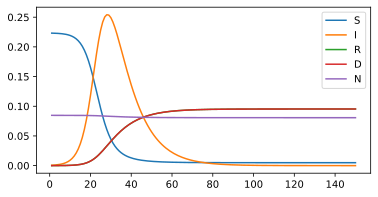

In [206]:
woplot(simulation_normalized,t)

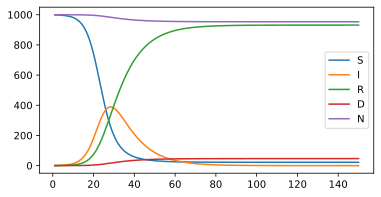

In [207]:
woplot(simulation,t)

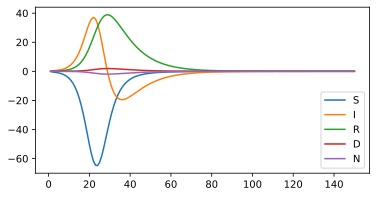

In [278]:
woplot(weifen,t)

In [252]:
# 普通线性网络，把时间加入
# def simple_with_time(data_with_time, batch_size, train_ratio):
#     total_size = len(data_with_time)
#     train_size = int(total_size * train_ratio)
#
#     train_dataset = TensorDataset(data_with_time[:train_size, -1].type(torch.float32),data_with_time[:train_size, :-1].type(torch.float32))
#     test_dataset = TensorDataset( data_with_time[train_size:, -1].type(torch.float32),data_with_time[train_size:, :-1].type(torch.float32))
#
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#
#     return train_loader, test_loader

def simple_with_time(data_with_time, batch_size, train_ratio):
    total_size = len(data_with_time)
    train_size = int(total_size * train_ratio)

    train_dataset = TensorDataset(data_with_time[:train_size, 1:].type(torch.float32),data_with_time[:train_size, 0].type(torch.float32))
    test_dataset = TensorDataset( data_with_time[train_size:, -1].type(torch.float32),data_with_time[train_size:, :-1].type(torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [253]:
train_data,test_data=simple_with_time(simulation_normalized,10,0.9)

In [255]:
for x,y in train_data:
    print(y)
    ss

tensor([0.2232, 0.2231, 0.2230, 0.2228, 0.2225, 0.2222, 0.2217, 0.2211, 0.2203,
        0.2193])


NameError: name 'ss' is not defined

In [273]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer=nn.Sequential(
            nn.Linear(5,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layer(x)

net = Net()
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.xavier_normal_(m.weight)
net.apply(init_weights)

Net(
  (layer): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

In [275]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
net.to(device)
for epoch in range(300):
    for X_train, y_train in train_data:
        # X_train = X_train.reshape(-1, 1)
        X_train = X_train.to(device)
        y_train=y_train.to(device)
        y_pred = net(X_train)
        # print(y_pred)
        # print(y_train)
        # ee
        optimizer.zero_grad()
        loss = criterion(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    # with torch.no_grad():
    #     test_loss = 0
    #     for X_test, y_test in test_data:
    #         X_test = X_test.reshape(-1, 1).to(device)
    #         y_test=y_test.to(device)
    #         y_pred = net(X_test)
    #         test_loss += criterion(y_pred.squeeze(), y_test).item()
    #
    # if epoch%10==0:
    #     print('Epoch:', epoch, 'Train loss:', loss.item(), 'Test loss:', test_loss/len(test_data))
net.to('cpu')

Net(
  (layer): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

In [276]:
# shuru=torch.tensor([1,2,3,4,5],dtype=torch.float32).reshape(-1, 1)
# _,_,shuru_normalized=guiyihua(shuru)
test=simulation_normalized[:,1:].float()
out=net(test).detach().numpy()
out

array([[0.00056047],
       [0.0005705 ],
       [0.00059195],
       [0.00063003],
       [0.00069347],
       [0.00079833],
       [0.00097233],
       [0.00122486],
       [0.00166096],
       [0.00244886],
       [0.00406083],
       [0.00764836],
       [0.01472213],
       [0.02915247],
       [0.05974352],
       [0.08162139],
       [0.07450686],
       [0.06627627],
       [0.06317847],
       [0.05949062],
       [0.05939743],
       [0.0610967 ],
       [0.05392292],
       [0.0385231 ],
       [0.00930422],
       [0.00026988],
       [0.00000253],
       [0.00000004],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00000012],
       [0.00000718],
       [0.00021067],
       [0.00203725],
       [0.00607808],
       [0.01004022],
       [0.0153018 ],
       [0.02614467],
       [0.0302934 ],
       [0.03546762],
       [0.0417721 ],
       [0.04829734],
       [0.05268106],
       [0.05819014],
       [0.058

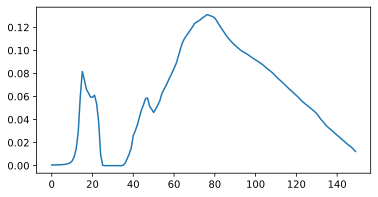

In [277]:
plt.plot(out)

In [185]:
denormalized_simulation = out * (col_max[:5] - col_min[:5]) + col_min[:5]
denormalized_simulation

tensor([[-9.4127e+02, -2.8740e+02, -1.9485e+02, -3.3812e+01,  8.8613e+02],
        [-8.6983e+02, -2.5492e+02, -1.7222e+02, -3.3236e+01,  8.8815e+02],
        [-8.0234e+02, -2.2080e+02, -1.4652e+02, -3.2338e+01,  8.9037e+02],
        [-7.4328e+02, -1.8163e+02, -1.1749e+02, -3.1460e+01,  8.9239e+02],
        [-6.8227e+02, -1.4594e+02, -8.7169e+01, -2.9771e+01,  8.9514e+02],
        [-6.3703e+02, -1.1067e+02, -6.0488e+01, -2.8053e+01,  8.9899e+02],
        [-5.8550e+02, -7.5001e+01, -3.3693e+01, -2.6377e+01,  9.0321e+02],
        [-5.2591e+02, -4.0241e+01, -6.2501e+00, -2.4655e+01,  9.0742e+02],
        [-4.5546e+02, -6.7701e+00,  2.1928e+01, -2.2869e+01,  9.1156e+02],
        [-3.8594e+02,  2.6953e+01,  5.0592e+01, -2.1119e+01,  9.1571e+02],
        [-3.1630e+02,  6.0717e+01,  7.9410e+01, -1.9354e+01,  9.1986e+02],
        [-2.4967e+02,  1.0110e+02,  1.1542e+02, -1.6835e+01,  9.2332e+02],
        [-2.0995e+02,  1.4369e+02,  1.5571e+02, -1.4094e+01,  9.2602e+02],
        [-1.9387e+02,  1.

In [18]:
# 用LSTM

In [55]:
train_data,test_data=simple_with_time(simulation_normalized,5,0.9)

In [56]:
class parameter_layer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(parameter_layer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_normal_(param)
            elif 'bias' in name:
                torch.nn.init.constant_(param, 0.0)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        # 转换维度
        x = x.view(x.size(0), 1, x.size(1))
        # 前向
        out, _ = self.lstm(x, (h0, c0))
        # 解码
        out = self.fc(out[:, -1, :])
        return out

In [57]:
class MyLinear(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyLinear,self).__init__()
        self.dS = parameter_layer(input_size, hidden_size, num_layers, output_size)
        self.dI = parameter_layer(input_size, hidden_size, num_layers, output_size)
        self.dR = parameter_layer(input_size, hidden_size, num_layers, output_size)
        self.dD= parameter_layer(input_size, hidden_size, num_layers, output_size)
        self.dN = parameter_layer(input_size, hidden_size, num_layers, output_size)
        # self.layer=nn.Sequential(
        #     nn.Linear(5,16),
        #     nn.ReLU(),
        #     nn.Linear(16,32),
        #     nn.ReLU(),
        #     nn.Linear(32,5),
        #     nn.Softmax(dim=1)
        # )
    def forward(self, x):
        dS = self.dS(x)
        dI = self.dI(x)
        dR = self.dR(x)
        dD = self.dD(x)
        dN = self.dN(x)
        output = torch.stack([dS, dI, dR, dD, dN], dim=0)
        return output


In [58]:
net=MyLinear(1,128,2,1)
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.xavier_normal_(m.weight)
net.apply(init_weights)
net.to(device)
loss = nn.MSELoss()
# optimizer= torch.optim.SGD(net.parameters(), lr=0.01)
optimizer_dS = torch.optim.Adam(net.dS.parameters(), lr=0.01)
optimizer_dI = torch.optim.Adam(net.dI.parameters(), lr=0.01)
optimizer_dR = torch.optim.Adam(net.dR.parameters(), lr=0.01)
optimizer_dD = torch.optim.Adam(net.dD.parameters(), lr=0.01)
optimizer_dN = torch.optim.Adam(net.dN.parameters(), lr=0.01)


In [59]:
num_epochs = 100
start=time.time()

for epoch in range(num_epochs):
    l_test=0
    for X,y in train_data:
        X=X.reshape(-1,1)
        X,y=X.to(device),y.to(device)

        optimizer_dS.zero_grad()
        out=net.dS(X).transpose(0, 1).squeeze()
        loss_dS=loss(out,y[:,0])
        loss_dS.backward()
        optimizer_dS.step()

        optimizer_dI.zero_grad()
        out=net.dI(X).transpose(0, 1).squeeze()
        loss_dI=loss(out,y[:,1])
        loss_dI.backward()
        optimizer_dI.step()

        optimizer_dR.zero_grad()
        out=net.dR(X).transpose(0, 1).squeeze()
        loss_dR=loss(out,y[:,2])
        loss_dR.backward()
        optimizer_dR.step()

        optimizer_dD.zero_grad()
        out=net.dD(X).transpose(0, 1).squeeze()
        loss_dD=loss(out,y[:,3])
        loss_dD.backward()
        optimizer_dD.step()

        optimizer_dN.zero_grad()
        out=net.dN(X).transpose(0, 1).squeeze()
        loss_dN=loss(out,y[:,4])
        loss_dN.backward()
        optimizer_dN.step()

        train_loss=loss_dS + loss_dI + loss_dR + loss_dD + loss_dN

        # print(f'train_loss is {train_loss}')



    with torch.no_grad():
        i=1
        for a,b in test_data:
            a=a.to(device)
            b=b.to(device)
            a=a.reshape(-1,1)
            out=net(a).transpose(0, 1).squeeze()
            l_test+= loss(out,b)
            i+=1
    print(f'epoch {epoch + 1}, loss {l_test/i}')
# print(time.time()-start)

epoch 1, loss 0.00025558890774846077
epoch 2, loss 0.00013720779679715633
epoch 3, loss 5.736167076975107e-05
epoch 4, loss 0.00017637398559600115
epoch 5, loss 7.962292875163257e-05
epoch 6, loss 0.0002707378880586475
epoch 7, loss 0.0002867454895749688
epoch 8, loss 0.0003658214118331671
epoch 9, loss 0.0002657960285432637
epoch 10, loss 0.0002265226503368467
epoch 11, loss 0.00019969281856901944
epoch 12, loss 0.00022274415823630989
epoch 13, loss 0.00023308239178732038
epoch 14, loss 0.00023802247596904635
epoch 15, loss 0.00023451083688996732
epoch 16, loss 0.00023660881561227143
epoch 17, loss 0.00023945438442751765
epoch 18, loss 0.00024090142687782645
epoch 19, loss 0.00023872635210864246
epoch 20, loss 0.0002357493940507993
epoch 21, loss 0.00023130295448936522
epoch 22, loss 0.00023620165302418172
epoch 23, loss 0.00023027406132314354
epoch 24, loss 0.00022014451678842306
epoch 25, loss 0.00015051572700031102
epoch 26, loss 0.00015377975068986416
epoch 27, loss 0.000179967697

tensor([[0.0009],
        [0.0019],
        [0.0028],
        [0.0038],
        [0.0047],
        [0.0056],
        [0.0066],
        [0.0075],
        [0.0084],
        [0.0094],
        [0.0103],
        [0.0113],
        [0.0122],
        [0.0131],
        [0.0141],
        [0.0150],
        [0.0159],
        [0.0169],
        [0.0178],
        [0.0188],
        [0.0197],
        [0.0206],
        [0.0216],
        [0.0225],
        [0.0235],
        [0.0244],
        [0.0253],
        [0.0263],
        [0.0272],
        [0.0281],
        [0.0291],
        [0.0300],
        [0.0310],
        [0.0319],
        [0.0328],
        [0.0338],
        [0.0347],
        [0.0356],
        [0.0366],
        [0.0375],
        [0.0385],
        [0.0394],
        [0.0403],
        [0.0413],
        [0.0422],
        [0.0432],
        [0.0441],
        [0.0450],
        [0.0460],
        [0.0469],
        [0.0478],
        [0.0488],
        [0.0497],
        [0.0507],
        [0.0516],
        [0

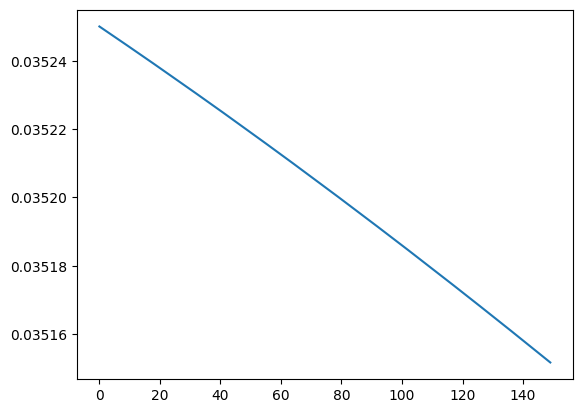

In [65]:
net.to('cpu')
test=simulation_normalized[:,-1].reshape(-1,1).float()
print(test)
pre=net.dI(test)
plt.plot(pre.detach())

In [268]:
denormalized_simulation = out * (col_max - col_min) + col_min

In [61]:
def get_data(data,tau,T):
    data=torch.tensor(data)
    features = torch.zeros((T - tau, tau))
    for i in range(tau):
        features[:, i] = data[i: T - tau + i]
    labels = data[tau:].reshape((-1, 1))
    batch_size, n_train = 10, 8000
    train_iter = d2l.load_array((features[:n_train], labels[:n_train]),batch_size, is_train=True)
    return train_iter,features,labels

In [62]:
dSdt, dIdt, dRdt, dDdt, dNdt=simulation[:,0],simulation[:,1],simulation[:,2],simulation[:,3],simulation[:,4]

In [63]:
tau = 1
S_train,S_features,S_labels=get_data(dSdt,tau,T)
I_train,I_features,I_labels=get_data(dIdt,tau,T)
R_train,R_features,R_labels=get_data(dRdt,tau,T)
D_train,D_features,D_labels=get_data(dDdt,tau,T)
N_train,N_features,N_labels=get_data(dNdt,tau,T)

In [66]:
class parameter_layer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(parameter_layer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_normal_(param)
            elif 'bias' in name:
                torch.nn.init.constant_(param, 0.0)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        # 转换维度
        x = x.view(x.size(0), 1, x.size(1))
        # 前向
        out, _ = self.lstm(x, (h0, c0))
        # 解码
        out = self.fc(out[:, -1, :])
        return out

In [50]:
class MyLinear(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyLinear,self).__init__()
        self.beta = parameter_layer(input_size, hidden_size, num_layers, output_size)
        self.gamma=parameter_layer(input_size, hidden_size, num_layers, output_size)
        self.I=nn.Sequential(
            nn.Linear(input_size,10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
    def forward(self, x):
        linear =self.beta(x)*self.I(x) +self.gamma(x)
        return linear

AttributeError: 'numpy.ndarray' object has no attribute 'type'